# City maker for the Weibull population distribution

__This file is dependent of__

* __citymaker.py__ : file with Python codes
* folder __data__ with 
    * __SUB-IP-EST2021-POP.xlsx__ : file with the U.S. Census data

The output consists of the model data distributions placed to __data__

## Definition of the cdf, pdf, and the key equation

Probability density function
$$
  f(x; \lambda, k, a) =c_{\text{norm}} \cdot \frac{k}{\lambda}
  \left(\frac{x+a}{\lambda}\right)^{k-1}
  e^{-( (x+a) /\lambda)^k},\quad 0 \leq x \leq M,
$$

where $c_{\text{norm}}=1/ (\ e^{-(a/\lambda)^k} - e^{-( (M+a) /\lambda)^k}\ ) $.

Cumulative distribution function
$$
  F(x; \lambda, k, a) =c_{norm} \cdot (\ e^{-(a/\lambda )^k} - e^{-( (x+a) /\lambda )^k}\ ),\quad 0 \leq x \leq M
$$


__Solving the equation__

$$
  F(m_{n+1}) - \sqrt{ \frac{f(m_{n+1})}{2} } = F(y_n)
  \quad\quad\quad\quad (\mathrm{EQ})
$$

with respect to $m_{n+1}$.
The solution defines the median of the jurisdiction


__Visualizing the left hand side of this equation to verify monotonicity__

This part is optional. One can switch to [constructing cities](#constructing_cities) immediately

lhs_max = 0.9999999999994238


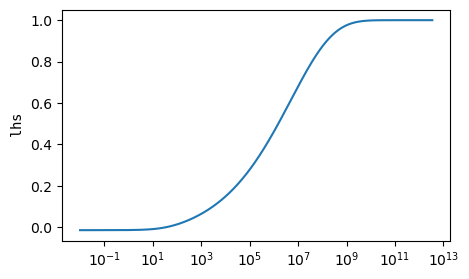

In [53]:
import numpy as np
from citymaker import weibull_left_hand_side, plot_weibull_lhs
fig, ax = plot_weibull_lhs(loc=-30, scale=5e+6, k=0.25, M=1e+11*9.06183*3.8097)
#the rightest value of <lhs> is printed

__Constructing model cities and saving them to files__<a id='constructing_cities'></a>

* output is formatted into two columns: relative density and the median of each city
* input parameters correspond to the choice of the paper

> We emphasize that small cities can have so minor population that the generation of new cities is senseless. The process is stopped by either the library solver or parameters __xtol__ and __stop__ (see below) so that the warming message from 

In [54]:
from citymaker import model_cities, efloat2txt
locs = [-30, -30]
scales = [5e+6, 5e+6]
kk = [0.25, 0.05]
MM = [1e+12, 1e+35]
for (loc, scale, k, M) in zip(locs, scales, kk, MM):
    #create cdf - cdf_vals[i] is the relative frequency of population in cities from 1 to i
    #and the medians - median[i] is the median of the i-th city, in line with the above equation
    #parameters:
    #k, loc, scale, M represent k, a, lambda, and M in the above equations
    #<xtol> indicates the tolerance when (EQ) is solved, default: 1e-9
    #the number of model cities is limited by <stop>; default: 100000
    #computation can be stopped by the library solver if further iterations does not change the solution
    #this is FEASIBLE outcome of the computation (can be avoided by increasing <xtol>)
    cdf_vals, median = model_cities(k, loc=loc, scale=scale, M=M, xtol=1e-11, stop=25000)
    #---save to file: give an appropriate outname
    loctxt = str(loc)
    scaletxt = format(scale, 'e')[:-1].replace('0', '').replace('.', '')+format(scale, 'e')[-1]
    ktxt = str(k).replace('.', '_')
    Mtxt = efloat2txt(M)
    oname = f'data/weibull{loctxt}a{scaletxt}l{ktxt}k{Mtxt}m.txt'
    #---given
    with open(oname, 'wt') as f: #writing to file
        f.write('pdf\tmedian\n')
        cdf_prv = 0
        for i in range(len(cdf_vals)-1):
            f.write('{:.10f}\t{:f}\n'.format(cdf_vals[i]-cdf_prv, median[i]))#control format
            cdf_prv = cdf_vals[i]

Number of cities is 5000
Number of cities is 10000
Number of cities is 15000
Number of cities is 20000


C:\Users\User\work\projects\zipf\code\citymaker.py:80: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root_new = fsolve(func, root, args=(k, loc, scale, cdf_cur), xtol=xtol)[0]#new median is a root


Number of cities is 5000
Number of cities is 10000
Number of cities is 15000
Number of cities is 20000
Number of cities is 25000
Maximal number of cities is reached


## Plotting the rank distribution with model and U.S. Census data

__Reading Census data__

* [source](https://www2.census.gov/programs-surveys/popest/tables/2020-2021/cities/totals/SUB-IP-EST2021-POP.xlsx) has been downloaded to the local computer and further used under the same name

__Plotting__

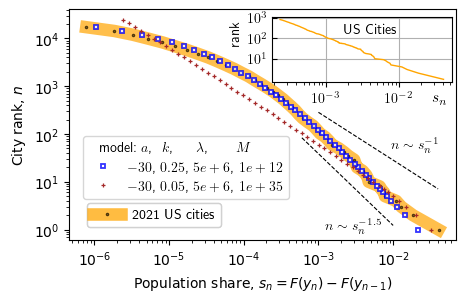

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from citymaker import efloat2txt, thinout, plt_fit, preprocess_census_full
df = pd.read_excel('data/SUB-IP-EST2021-POP.xlsx', skiprows=3)#first 3 rows are not data
dfcensus = preprocess_census_full_xslx(df) #sorting relative population of U.S. cities
#---parameters of the filenames and curves
lgap = [1.20, 1.20]#log-x-gap between successive points in the graphs
clr = ['blue', 'brown']
marker = ['s', '+']
msize = [2.8, 3]
medgewd = [1.3, 0.9]
alpha = [0.8, 1]
loc = [-30, -30]
scale = [5e+6, 5e+6]
kk = [0.25, 0.05]
MM = [1e+12, 1e+35]
loctxt = [str(lo) for lo in loc]
scaletxt = [format(s, 'e')[:-1].replace('0', '').replace('.', '')+format(s, 'e')[-1] for s in scale]
ktxt = [str(k).replace('.', '_') for k in kk]
Mtxt = [efloat2txt(M) for M in MM]
rnk_max = [20000, 100000]
#---adjusting of the figure
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
rc_fonts = {
    "text.usetex": True,
    'mathtext.default': 'regular',
    "text.latex.preamble": r"\usepackage{bm,amssymb,amsmath}",
}
plt.rcParams.update(rc_fonts)
#---plotting rank distribution with the U.S. Census data
rnk_us, pdf_us = thinout(dfcensus['rank'], dfcensus['pdf21'], 1.2) #save when rank_new >= rank_previous * 1.2
hc, = ax.plot(pdf_us, rnk_us, color='orange', alpha=0.7,
       linewidth=9, marker='.', markeredgecolor='black', markersize=3)
#---plotting rank distribution with the model
for i in range(len(kk)):
    name = f'data/weibull{loctxt[i]}a{scaletxt[i]}l{ktxt[i]}k{Mtxt[i]}m.txt'
    df = pd.read_csv(name, sep='\t')
    rank = [j+1 for j in range(len(df))]
    #plot only part of the points for the sake of visibility
    rank4plot, val4plot = thinout(rank[:rnk_max[i]], df['pdf'][:rnk_max[i]], lgap[i])
    ax.plot(val4plot, rank4plot, marker=marker[i], linestyle = '', markeredgewidth=medgewd[i], 
            markerfacecolor='w', markeredgecolor=clr[i], markersize=msize[i],
            label='${:d}$, ${:.2f}$, ${:s}$, ${:s}$'.format(loc[i], kk[i], scaletxt[i], Mtxt[i]), 
            alpha=alpha[i])
#---power-laws
gamma1 = -1
x1 = np.geomspace(1e-3, 4e-2)
y1 = np.exp(gamma1*np.log(x1)) / pdf_us[0]**gamma1 * 7
pl1 = ax.plot(x1, y1, linestyle='--', color='black', lw=0.8)
ax.text(x1[-1], y1[-1]*7, f'$n\\sim s_n^{{{gamma1}}}$', ha='right')
gamma2 = -1.50
x2 = np.geomspace(6e-4, 1e-2)
y2 = np.exp(gamma2*np.log(x2)) / pdf_us[0]**gamma2 * 0.15
pl2 = ax.plot(x2, y2, linestyle='--', color='black', lw=0.8)
ax.text(0.7*x2[-1], 0.8*y2[-1], f'$n\\sim s_n^{{{gamma2}}}$', ha='right')
legend1 = ax.legend(title='model: $\\!a$, $\\ k$, $\\ \\ \\ \\ \\lambda$, $\\ \\ \\ \\ \\ M$',
                   loc='best', bbox_to_anchor=(0.02, 0.15, 0.50, 0.5))
legend1.get_title().set_position((-11, 0))
ax.add_artist(legend1)
legend2 = ax.legend([hc], ['2021 US cities'], 
                    loc='best', bbox_to_anchor=(0.02, 0.04, 0.39, 0.15))
ax.add_artist(legend2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Population share, $s_n = F(y_{n}) - F(y_{n-1})$')#, fontsize=fsize
ax.set_ylabel(r'City rank, $n$')
#---inset
rnk4ins = 800
axins = ax.inset_axes([dfcensus['pdf21'][rnk4ins], 1.5*dfcensus['rank'][rnk4ins], 
                        1.5*dfcensus['pdf21'][0]-dfcensus['pdf21'][rnk4ins], 
                       ax.get_ylim()[-1]*0.7-1.5*dfcensus['rank'][rnk4ins]], transform=ax.transData)
hcins, = axins.plot(dfcensus['pdf21'][:rnk4ins], dfcensus['rank'][:rnk4ins], color='orange', lw=1)
axins.text(0.4, 0.75, 'US Cities', ha='left', transform=axins.transAxes)
axins.set_xscale('log')
axins.set_yscale('log')
axins.set_yticks([10, 100, 1000])
axins.tick_params(axis='y', which='both', direction='in')
axins.grid()
ht = ax.text(1.3*dfcensus['pdf21'][0], 0.50*rnk4ins, '$s_n$', ha='right', va='bottom')
ht.set_fontsize(ht.get_fontsize()+1)
ax.text(dfcensus['pdf21'][rnk4ins]*0.40, 10*rnk4ins, 'rank', ha='right', rotation=90)
plt.rcdefaults()  # restore the defaults changed with plt.rcParams.update()


```python
#copy the following lines to the code cells is the module has to be reloaded
import importlib
import citymaker
importlib.reload(citymaker)
```